<a href="https://colab.research.google.com/github/ssenhouse/datakit-housing-fall-2024/blob/main/challenge-2/DataKind_HousingProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Florida Housing Project**

Challenge 2 - Anticipating Household Displacement in Communities
Source data provided by Data Kind "Data Kit"

In [1]:
!pip install hvplot
!pip install holoviews
!pip install geoviews
!pip install census
!pip install us

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 2.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of panel to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.2/563.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 60.5 MB/s eta 0:00:00
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.4.3
    Uninstalling bokeh-3.4.3:
      Successfully uninstalled bokeh-3.4.3
  Attempting uninstall: panel
    Found existing installation: panel 1.4.5
    Uninstalling panel-1.4.5:
      Successfully uninstalled panel-1.4.5


In [2]:
# importing dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import hvplot.pandas
import holoviews as hv
import geoviews as gv
import matplotlib.cm as cm
hv.extension('bokeh')
import os
import re
import seaborn as sns
import zipfile
import requests,io
from census import Census
from us import states
from pathlib import Path




In [26]:
# importing data set from datakit-houseing-fall-2024

url = 'https://github.com/ssenhouse/datakit-housing-fall-2024/raw/main/challenge-2/2024-09-22_%20Florida_%20Osceola_data.zip' # changed url to point to the raw file
filename = "data.csv" # changed the filename to the actual name of the file within the zip archive

r = requests.get(url)

with zipfile.ZipFile(io.BytesIO(r.content)) as myzip:
    with myzip.open(filename) as myfile:
        df = pd.read_csv(myfile)
#df

In [27]:

# Assuming you want to remove rows where med_hh_inc_est is -666666666.
df = df[df.med_hh_inc_est != -666666666]

# If you want to remove rows where housecost_owner_est is -666666666:
df = df[df.housecost_owner_est != -666666666]

# If you want to remove rows where housecost_rent_est is -666666666:
df = df[df.housecost_rent_est != -666666666]

# convert median household income from annual to monthly income
df['med_hh_inc_est_monthly'] = df['med_hh_inc_est'] / 12
df.head()

,geoid,geoid_year,state,county,state_fips_code,county_fips_code,gini_index_est,med_hh_inc_est,pop_pct_60plus_est,med_mortgage_loan,housecost_owner_est,housecost_rent_est,med_hh_inc_est_monthly
0,12097040807,2020,Florida,Osceola County,12,97,0.5799,76582,28.8,255000.0,1791,1593,6381.833333
1,12097041101,2020,Florida,Osceola County,12,97,0.3293,52466,20.3,245000.0,1197,1556,4372.166667
2,12097041302,2020,Florida,Osceola County,12,97,0.4914,58267,13.8,205000.0,1271,1589,4855.583333
3,12097041502,2020,Florida,Osceola County,12,97,0.4609,76035,23.0,275000.0,1611,1705,6336.250000
4,12097042000,2020,Florida,Osceola County,12,97,0.4782,49278,12.2,245000.0,1738,1505,4106.500000


In [30]:
# Calculate the percentage AMI for renters and store it in a new column
df['%_of_med_monthly_inc_renters'] = df['housecost_rent_est'] / df['med_hh_inc_est_monthly']

# Calculate the percentage AMI for homeowners and store it in a new column
df['%_of_med_monthly_inc_homeowners'] = df['housecost_owner_est'] / df['med_hh_inc_est_monthly']

#calculate the percentage AMI for Osceola county which is 90.4k
df['%_of_AMI_Osceola'] = df['med_hh_inc_est'] / 90400
df.head()

,geoid,geoid_year,state,county,state_fips_code,county_fips_code,gini_index_est,med_hh_inc_est,pop_pct_60plus_est,med_mortgage_loan,housecost_owner_est,housecost_rent_est,med_hh_inc_est_monthly,%_of_med_monthly_inc_renters,%_of_med_monthly_inc_homeowners,%_of_AMI_Osceola
0,12097040807,2020,Florida,Osceola County,12,97,0.5799,76582,28.8,255000.0,1791,1593,6381.833333,0.249615,0.280640,0.847146
1,12097041101,2020,Florida,Osceola County,12,97,0.3293,52466,20.3,245000.0,1197,1556,4372.166667,0.355888,0.273777,0.580376
2,12097041302,2020,Florida,Osceola County,12,97,0.4914,58267,13.8,205000.0,1271,1589,4855.583333,0.327252,0.261761,0.644546
3,12097041502,2020,Florida,Osceola County,12,97,0.4609,76035,23.0,275000.0,1611,1705,6336.250000,0.269087,0.254251,0.841095
4,12097042000,2020,Florida,Osceola County,12,97,0.4782,49278,12.2,245000.0,1738,1505,4106.500000,0.366492,0.423231,0.545111


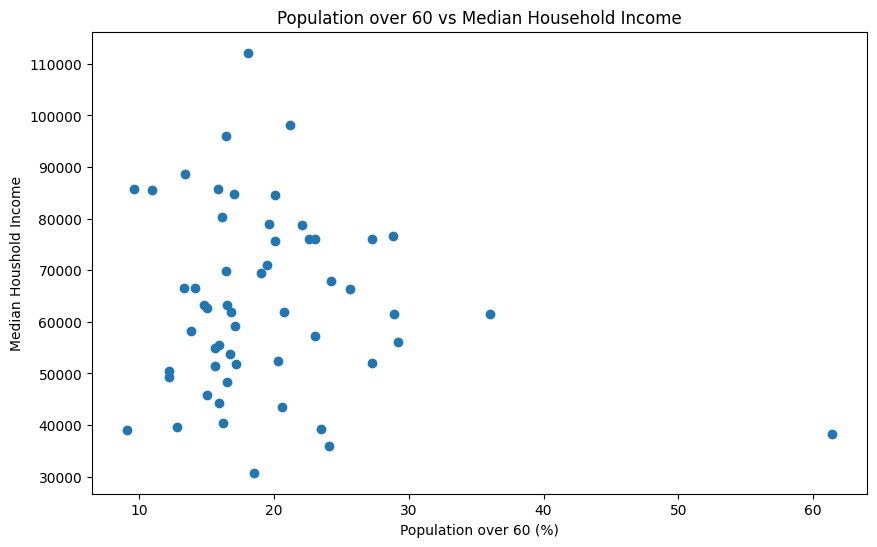

In [35]:
# @title Population over 60 vs Median Household Income

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df['pop_pct_60plus_est'], df['med_hh_inc_est'])
plt.xlabel('Population over 60 (%)')
plt.ylabel('Median Houshold Income')
_ = plt.title('Population over 60 vs Median Household Income')

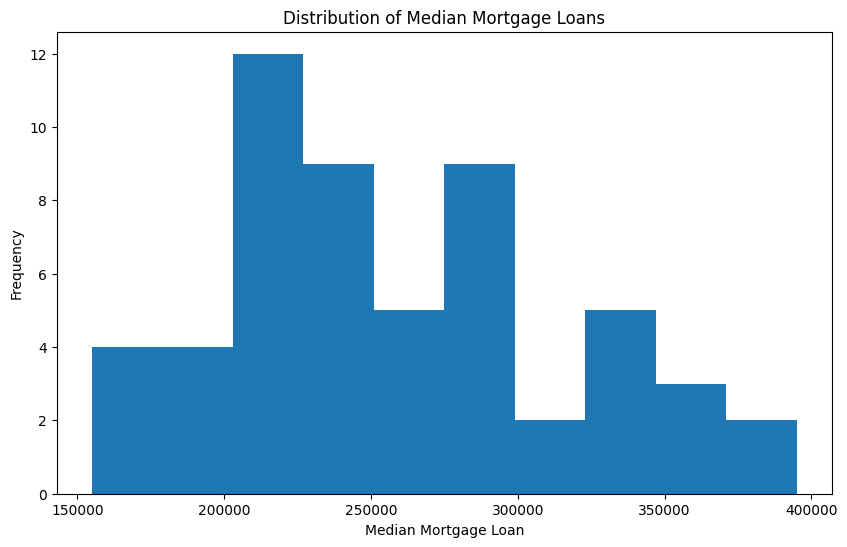

In [34]:
# @title Distribution of Median Mortgage Loans

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['med_mortgage_loan'])
plt.xlabel('Median Mortgage Loan')
plt.ylabel('Frequency')
_ = plt.title('Distribution of Median Mortgage Loans')

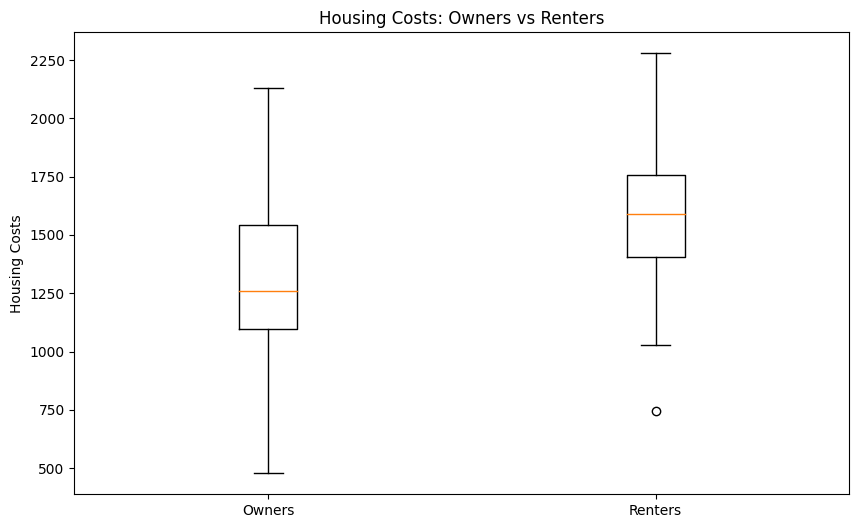

In [33]:
# @title Housing Costs: Owners vs Renters

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([df['housecost_owner_est'], df['housecost_rent_est']], labels=['Owners', 'Renters'])
plt.ylabel('Housing Costs')
_ = plt.title('Housing Costs: Owners vs Renters')